In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(rasqualTools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(parallel))

In [2]:
coln = c('Feature','rsID','Chromosome','position','Ref' ,'Alt' ,'Af','HWEChi_square' ,'IA','Log10_qval','Chi_square',
        'Effect_size','Sequencing_mapping_error_rate','Ref_allele_bias' ,'Overdispersion','SNPid_within_region',
        'No_fSNPs','No_tested_SNPs','No_iterations_for_H0','No_iterations_for_H1',"ties",'Log_likelihood_H0',
        'Convergence_status','r2_fSNPs','r2_rSNP')

In [14]:
rasqual_caQTL = function(x, snp_counts, counts, offsets, covariates,  vcf=vcf_file, outdir, outlogdir,
                         nsamples=13, lead=TRUE, permut=FALSE) 
{
region  = paste0(snp_counts$chromosome_name[x], ":",snp_counts$range_start[x] ,"-",snp_counts$range_end[x])
outfile = paste0(outdir, "/",  snp_counts$gene_id[x])   

outlog    = paste0(outlogdir,"/",  snp_counts$gene_id[x], ".log")
    
system(paste("tabix",  vcf, region, "| $RASQUALDIR/bin/rasqual", 
'-y', counts,
'-k', offsets,
'-x', covariates,
"-n", nsamples,             
'-j', indexes[x] ,
'-l', snp_counts$cis_snp_count[x] ,
'-m', snp_counts$feature_snp_count[x] , 
'-s', snp_counts$exon_starts[x],
'-e', snp_counts$exon_ends[x] , 
'-f', snp_counts$gene_id[x],
 c("","-t" )  [(lead==TRUE) +1]   ,
 c("","-r" )  [(permut==TRUE) +1]   ,
#'--min-coverage-depth 6',
'>', outfile, "2>", outlog))
    
}

In [33]:
###### set parmetes here ######
maindir     = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/fine/'
celltypes   = list.files(maindir)[!grepl(".txt", list.files(maindir))]
P           =  FALSE ## permutation?  ## not necessary with the new vcf files
folder_name = 'run2_perm2_lead'
L           =  TRUE ## report only lead?
nsamples    = 13
####################################

setwd(maindir)

In [34]:
folder_name

[1] "run2_perm2_lead"

In [ ]:
for (c in celltypes){

cat (c, "\n")
counts      = paste0( c, "/counts.",c, ".bin" )
offsets     = paste0( c, "/size_factors.",c, ".bin" )
covariates  = paste0( c, "/covariates.",c, ".bin" )

inp = read.table(paste0( c, "/counts.",c, ".txt" ), row.names=1)
cm  = read.table(paste0( c,"/",c, ".count_matrix" ), header=T, stringsAsFactors = F)

peak_data = cm[,c(1,2,5,3,4)]
peak_data$Strand = as.integer(1)
colnames(peak_data) =  c('gene_id','chr','strand','exon_starts','exon_ends')
peak_data$exon_starts = as.character(peak_data$exon_starts)
peak_data$exon_ends = as.character(peak_data$exon_ends)

vcf_dir = paste0(c, '/vcfs_peaksonly/' )
    
system(paste0("bcftools query -f '%CHROM\\t%POS\\t%ID\\n' ", 
              vcf_dir,  "full.ase.filtered.vcf.gz > ",  vcf_dir, 'full.ase.filtered.snps'))
   
snps2           = read.table(paste0(vcf_dir, "full.ase.filtered.snps"))
colnames(snps2) = c('chr','pos','snp_id')
    
snp_counts2 = countSnpsOverlapingExons(peak_data, snps2, cis_window = 10000)
snp_counts2 = subset(snp_counts2, feature_snp_count>0 |  cis_snp_count> 0)
snp_counts_sub = subset(snp_counts2, gene_id %in% rownames(inp))

indexes =  match ( snp_counts_sub$gene_id,rownames(inp))

cat(sum(rownames(inp[indexes,])!= snp_counts_sub$gene_id), "\n")

sp = split(snp_counts_sub, snp_counts_sub$chromosome_name)

for ( n in 1:22){

chrom  = paste0("chr", n)
outdir = paste( c, folder_name , chrom, sep ="/")
system(paste('mkdir -p', outdir))
outlogdir = paste0(outdir, "/logs")
system(paste("mkdir",outlogdir ))

snp_counts_use = sp[[chrom]]
indexes        =  match ( snp_counts_use$gene_id,rownames(inp))

#vcf_file = paste0(vcf_dir,  'full.ase.filtered.vcf.gz' )
    
  ### vcfs to use for permuations  not for eur only
#vcf_file = paste0(vcf_dir,  'full.ase.filtered.allelic.perm1.vcf.gz' )
vcf_file = paste0(vcf_dir,  'full.ase.filtered.allelic.perm2.vcf.gz' )

mclapply(1:nrow(snp_counts_use), function(x) rasqual_caQTL(x, snp_counts_use, counts, offsets, covariates, 
                                                           nsamples=nsamples, 
                                                           vcf=vcf_file, outdir=outdir, outlogdir=outlogdir ,
                                                           lead=L, permut=P) , mc.cores = 40 )
         }
    
    }

In [ ]:
for (c in celltypes){
    logdir = paste0( c, "/",folder_name , "_logs")
    dir.create(logdir)
for ( n in 1:22){
        chrom  = paste0("chr", n)
        outdir = paste( c, folder_name , chrom, "logs",sep ="/")
        files = na.omit(list.files(outdir)[sapply(paste(outdir, list.files(outdir),sep="/"), file.size) >0])
 if(length(files)>0) {      
    error_files= paste(outdir, files, sep="/")
     for (err in error_files){
     system(paste("mv", err, logdir))
    }
     }
    system(paste("rm -r",outdir ))
    
            }
    
    }

In [ ]:
folder_name

In [ ]:
compile_results = function(n,folder_name,outdir ){
  	    chrom  = paste0("chr", n)
        outdir = paste( c, folder_name , chrom, sep ="/")
        system(paste0("cat ", outdir,  "/* > ", c , "/", folder_name,".results_chr", n))
    }


for (c in celltypes){
    cat (c, "\n")
    tabname = paste0(c, "/Results_", folder_name, ".tsv")
    
        
 mclapply (1:22, function(x) compile_results(n=x,folder_name=folder_name,outdir=outdir))
         
        system(paste0("cat ", c , "/", folder_name,".results_chr* > ", tabname))
        system(paste0("rm ", c , "/", folder_name,".results_chr*"))
         results           = read.table(tabname, fill=T)
         colnames(results) = coln
         results           = subset(results,results$rsID !="SKIPPED")
         results$P_VAl     = pchisq(results[,11], 1, lower=F)
         write.table(results, tabname, sep="\t", quote=F)

}


In [30]:
c

[1] "tReg"

In [7]:
for (c in celltypes){
    for ( n in 1:22){
        chrom  = paste0("chr", n)
        outdir = paste( c, folder_name , chrom, sep ="/")         
        system(paste0("rm -r ", outdir))
        
            }
    system(paste0("rm -r ", c, "/", folder_name))
 }

### Calculte empirical q-value from the permutations.
see: https://github.com/natsuhiko/rasqual/issues/21

In [39]:
# q1 : real lead Q-value vector for all peaks from RASQUAL
# q0 : permutated Q-value vector
# alpha : FDR threshold
# This function returns the P-value threshold corresponding to FDR=alpha.
getFDR <-
function(q1, q0, alpha=0.1, z=NULL, subset=NULL){
	if(is.null(z)){
		a=0
		for(itr in 1:10){
			a=getFDR(q1,q0,alpha,rev(a+0:100/100^itr),subset)
		}
		a
	}else{
		if(!is.null(subset)){
			q1=q1[subset]
			q0=q0[subset]
		}
		q1=q1[!is.na(q1)]
		q0=q0[!is.na(q0)]
		x=NULL;
		for(i in z){
			x=c(x,sum(q0<i)/length(q0)/(sum(q1<i)/length(q1)))
		};
		max(c(0,z[x<alpha]),na.rm=T)
	}
}


In [40]:
df = data.frame()
for (c in celltypes) {
results       = read.table(paste0(c, "/Results_run2_all.tsv"), header=T, stringsAsFactors = F)
random        = read.table(paste0(c, "/Results_run2_perm1_lead.tsv"), header=T, stringsAsFactors = F)
random2       = read.table(paste0(c, "/Results_run2_perm2_lead.tsv"), header=T, stringsAsFactors = F)
results       = results[order(results$P_VAl),]
results_lead  = results[!duplicated(results$Feature),]
    
thresh10      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.1) 
thresh05       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.05) 
thresh01       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.01) 

results_lead$flag_fdr10 = 10^(results_lead$Log10_qval) < thresh10
results_lead$flag_fdr05 = 10^(results_lead$Log10_qval) < thresh05
results_lead$flag_fdr01 = 10^(results_lead$Log10_qval) < thresh01
df = rbind(df, c(thresh10, sum(results_lead$flag_fdr10, na.rm=T) , 
                   thresh05, sum(results_lead$flag_fdr05, na.rm=T),
                   thresh01, sum(results_lead$flag_fdr01, na.rm=T)))

write.table(results_lead, paste0(c, "/Results_run2_lead.tsv"),sep="\t", quote=F, row.names=F)    

}
rownames(df) = celltypes
colnames(df) = c('pval_fdr10%', 'caQTL_fdr10%', 'pval_fdr05%', 'caQTL_fdr05%','pval_fdr01%', 'caQTL_fdr01%')

In [41]:
write.table(df, "Summary_run2.txt", quote=F)

In [42]:
df

,pval_fdr10%,caQTL_fdr10%,pval_fdr05%,caQTL_fdr05%,pval_fdr01%,caQTL_fdr01%
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
act_cd4_t,0.06662887,1223,0.019745626,695,3.118482e-04,204
adaptive_NK,0.04633303,43,0.026712583,24,9.635394e-03,8
cDC,0.04756613,62,0.025588090,40,1.273165e-02,32
cMono,0.05576338,2874,0.013030244,1537,1.768825e-04,405
cyto_cd8_t,0.05546999,711,0.018113963,418,1.983782e-04,86
cyto_nk,0.07221329,989,0.036202942,680,6.446909e-03,331
iMono,0.11263825,374,0.005887330,67,1.289376e-04,22
mem_b,0.10447297,342,0.038284657,151,1.111574e-02,75
mem_cd8_t,0.06987100,338,0.035336518,206,9.627118e-03,101


In [45]:
t(head(results_lead))

,13992,45610,75248,6249,49791,78240
Feature,chr11:18433609-18434198,chr19:54040398-54042103,chr6:32577458-32578288,chr1:38155996-38156519,chr2:232378786-232379625,chr7:134831931-134833621
rsID,chr11:18433780:A:G,chr19:54040861:G:C,chr6:32577811:C:T,chr1:38158211:C:T,chr2:232379455:C:G,chr7:134833578:C:T
Chromosome,chr11,chr19,chr6,chr1,chr2,chr7
position,18433780,54040861,32577811,38158211,232379455,134833578
Ref,A,G,C,C,C,C
Alt,G,C,T,T,G,T
Af,0.730769,0.269231,0.807692,0.192308,0.076923,0.615385
HWEChi_square,1.764543,1.764543,0.859592,0.736961,0.090278,5.078125
IA,0.989752,0.985363,0.992824,0.999916,0.999800,0.998500
Log10_qval,-8.696323,-5.878193,-5.167434,-4.353903,-3.950358,-4.463725


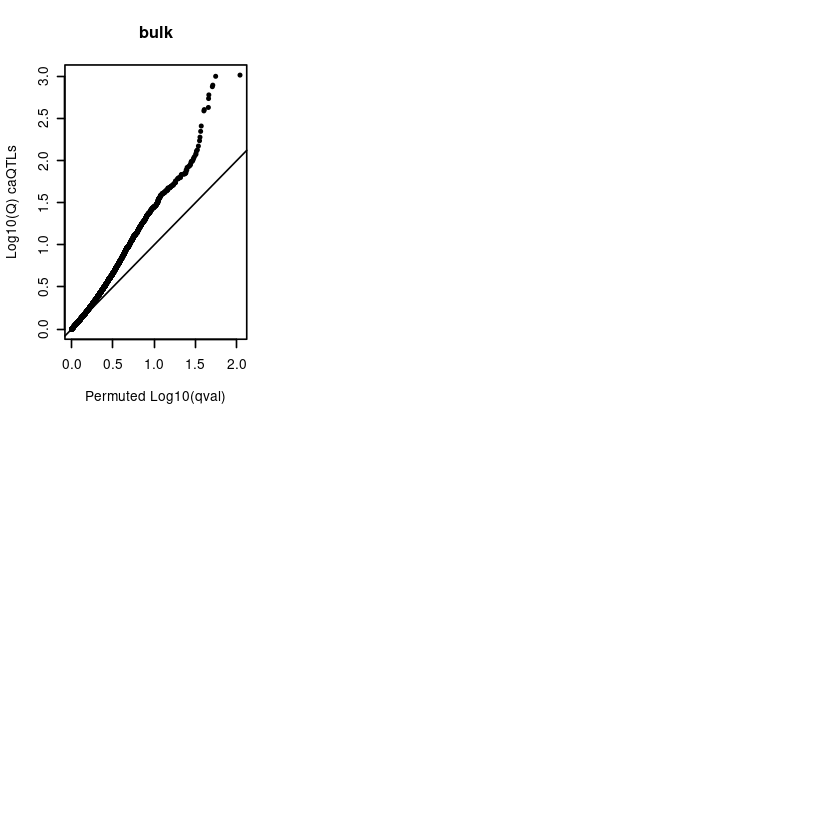

In [71]:
res = data.frame()
par(mfrow=c(2,3))
for (c in celltypes) {
results_lead       = read.table(paste0(c, "/Results_run1_lead.tsv"), header=T, stringsAsFactors = F)
random             = read.table(paste0(c, "/Results_run1_perm1_lead.tsv"), header=T, stringsAsFactors = F)
 
p1 = sort(-results_lead[,10])
p2 = sort(-random[,10])
plot(p2, p1, pch=20, cex=0.6, xlab="Permuted Log10(qval)", ylab="Log10(Q) caQTLs", main=c)
abline(0,1)
    results_lead$cell =c
   res= rbind(res,results_lead )
    }